### Digit Recognizer using CNN

In [4]:
#Run this cell if running file through google collab, else disable it 
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload() #upload kaggle.json obtained from Kaggle account
import os 
os.environ['KAGGLE_CONFIG_DIR']= '/content'
!chmod 600 /content/kaggle.json #read/write access

#Access dataset through Kaggle
!kaggle competitions download -c digit-recognizer #download dataset
!unzip -q digit-recognizer.zip -d . #unzip

# #If uploading dataset, upload through files.upload()
# !unzip -q train.csv.zip -d .
# !unzip -q test.csv.zip -d .

!ls

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=91b58a4787193a83b3b06a59201a1c10f0dd834e280f76bf9a5de86a1b98779c
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


Saving kaggle.json to kaggle.json
 59% 9.00M/15.3M [00:00<00:00, 35.2MB/s]
100% 15.3M/15.3M [00:00<00:00, 51.4MB/s]
digit-recognizer.zip  sample_data	     test.csv
kaggle.json	      sample_submission.csv  train.csv


In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf 
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, SGD, Adam
from keras import regularizers, initializers

In [6]:
#Loading the Dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
# Seperating the independent feature as y
y = train['label']
#drop the label column from the train dataset 
train = train.drop('label', axis =1)

In [8]:
sns.set(style='white', context='notebook', palette='deep')
# g = sns.countplot(y)
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [9]:
# Normalize the data
train = train / 255.0
test = test / 255.0
#convert df to array
train = np.array(train)
test= np.array(test) 
#Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
#For RGB images, there is 3 channels: 28x28x3
train = train.reshape(train.shape[0], 28, 28,1)
test = test.reshape(test.shape[0], 28, 28,1)

In [10]:
#split data set
X_train, X_val, Y_train, Y_val = train_test_split(train, y, test_size=0.2, random_state =42)

#Converting the train and validation labels to one-hot encodings
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=10)

In [ ]:
#CNN architecture  
#Note: Valid padding = no padding; Same padding = zero padding
#kernel_initializer setup for relu
he = initializers.he_uniform(seed=None)

batch_size=64
epochs = 15
neurons = [[32,64], [64,128], [128,256]]
custom_optimizer= [SGD(lr=0.001, momentum=0.9), Adam(), RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)]
train_acc=[]
test_acc=[]

for layer in neurons:
  model = Sequential()
  # Convolutional layers and Pooling
  model.add(Conv2D(filters=layer[0], kernel_size=5, kernel_initializer=he, activation="relu", input_shape=[28, 28, 1]))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=layer[1], kernel_size=5, activation="relu"))
  model.add(MaxPool2D(2,2))
  model.add(Dropout(0.25))
  # Flattening
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  #output dense layer
  model.add(Dense(units=10, activation='softmax'))

  for optimizer in custom_optimizer:
    #compile the model
    model.compile(optimizer=custom_optimizer[0], loss='categorical_crossentropy', metrics=["accuracy"])

    #data augmentation to prevent overfitting; expand the training dataset with variations 
    datagen = ImageDataGenerator(
        rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # randomly zoom image 
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
        )
    datagen.fit(X_train)
    #fit the model ; include callbacks here if needed 
    history= model.fit_generator(datagen.flow(X_train, Y_train, batch_size= batch_size), 
                                epochs =epochs, validation_data = (X_val, Y_val),
                                steps_per_epoch=X_train.shape[0] // batch_size, verbose =1)
    train_acc.append(history.history['accuracy'])
    test_acc.append(history.history['val_accuracy'])

# model.summary()
# from keras.utils import plot_model
# plot_model(model, show_shapes= True, show_layer_names= True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
525/525 [==============================] - 10s 19ms/step - loss: 1.2449 - accuracy: 0.5920 - val_loss: 0.2770 - val_accuracy: 0.9408
Epoch 2/15
525/525 [==============================] - 10s 19ms/step - loss: 0.6173 - accuracy: 0.8086 - val_loss: 0.1416 - val_accuracy: 0.9612
Epoch 3/15
525/525 [==============================] - 10s 19ms/step - loss: 0.4481 - accuracy: 0.8635 - val_loss: 0.1053 - val_accuracy: 0.9706
Epoch 4/15
525/525 [==============================] - 10s 19ms/step - loss: 0.3517 - accuracy: 0.8931 - val_loss: 0.0852 - val_accuracy: 0.9758
Epoch 5/15
525/525 [==============================] - 10s 19ms/step - loss: 0.3041 - accuracy: 0.9071 - val_loss: 0.0734 - val_accuracy: 0.9792
Epoch 6/15
525/525 [==============================] - 10s 19ms/step - loss: 0.2608 - accuracy: 0.9201 - val_loss: 0.0668 - val_accuracy: 0.9795
Epoch 7/15
525/525 [==============================] - 10s 19

In [ ]:
#Neurons:(32,64), Optimizer:SGD
trn_1 = train_acc[0]
val_1 = test_acc[0]
#Neurons:(32,64), Optimizer:Adam
trn_2 = train_acc[1]
val_2 = test_acc[1]
#Neurons:(32,64), Optimizer:RMSprop
trn_3 = train_acc[2]
val_3 = test_acc[2]
#Neurons:(64,128), Optimizer:SGD
trn_4 = train_acc[3]
val_4 = test_acc[3]
#Neurons:(64,128), Optimizer:Adam
trn_5 = train_acc[4]
val_5 = test_acc[4]
#Neurons:(64,128), Optimizer:RMSprop
trn_6 = train_acc[5]
val_6 = test_acc[5]
#Neurons:(128,256), Optimizer:SGD
trn_7 = train_acc[6]
val_7 = test_acc[6]
#Neurons:(128,256), Optimizer:Adam
trn_8 = train_acc[7]
val_8 = test_acc[7]
#Neurons:(128,256), Optimizer:RMSprop
trn_9 = train_acc[8]
val_9 = test_acc[8]

epochs = range(1, len(trn_1) + 1)


Text(0.5, 1.0, 'Training & Testing Accuracy with (128,256) neurons')

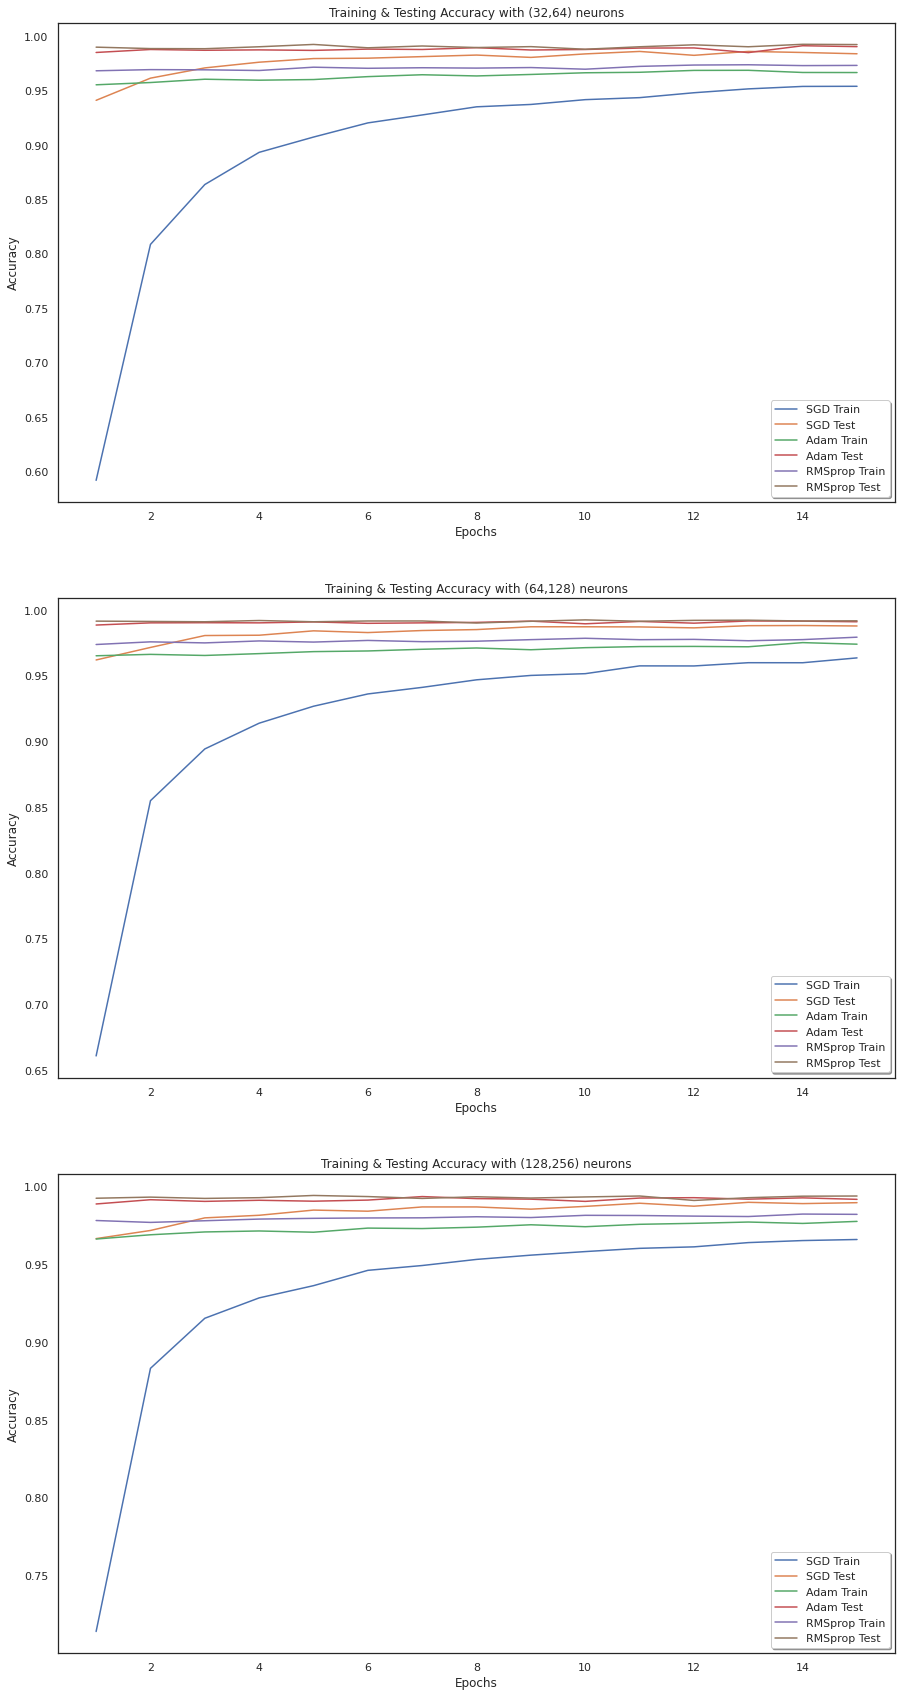

In [ ]:
#plot
fig, ax = plt.subplots(3,1,figsize=(15,30))
ax[0].plot(epochs, trn_1, label='SGD Train')
ax[0].plot(epochs, val_1, label='SGD Test')
ax[0].plot(epochs, trn_2, label='Adam Train')
ax[0].plot(epochs, val_2, label='Adam Test')
ax[0].plot(epochs, trn_3, label='RMSprop Train')
ax[0].plot(epochs, val_3, label='RMSprop Test')
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set(xlabel="Epochs", ylabel="Accuracy")
ax[0].set_title('Training & Testing Accuracy with (32,64) neurons')


ax[1].plot(epochs, trn_4, label='SGD Train')
ax[1].plot(epochs, val_4, label='SGD Test')
ax[1].plot(epochs, trn_5, label='Adam Train')
ax[1].plot(epochs, val_5, label='Adam Test')
ax[1].plot(epochs, trn_6, label='RMSprop Train')
ax[1].plot(epochs, val_6, label='RMSprop Test')
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set(xlabel="Epochs", ylabel="Accuracy")
ax[1].set_title('Training & Testing Accuracy with (64,128) neurons')

ax[2].plot(epochs, trn_7, label='SGD Train')
ax[2].plot(epochs, val_7, label='SGD Test')
ax[2].plot(epochs, trn_8, label='Adam Train')
ax[2].plot(epochs, val_8, label='Adam Test')
ax[2].plot(epochs, trn_9, label='RMSprop Train')
ax[2].plot(epochs, val_9, label='RMSprop Test')
legend = ax[2].legend(loc='best', shadow=True)
ax[2].set(xlabel="Epochs", ylabel="Accuracy")
ax[2].set_title('Training & Testing Accuracy with (128,256) neurons')

By Increasing the number of neurons from 32,64 to 64,128 and to 128,256 we can see that the overall accuracy for both the validation and the training has increased. As more neurons are added to a model, the model will be able to learn more from the data. We can see from the 3rd plot that the average accuracy is clustered together compared to the other two network. 



When we compare the three optimizers we can see that the best performing optimizer is RMSprop followed by Adam. SGD performed the worst in all 3 cases. I kept the default parameters for all the optimizers. When using Adam and RMSprop the lose converged faster as compared to the SGD. 

In [ ]:
#3 Layer CNN architecture 
model = Sequential()
# Convolutional layers and Pooling
model.add(Conv2D(filters=32, kernel_size=5, padding='same', kernel_initializer=he, activation="relu", input_shape=[28, 28, 1]))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, padding='same', kernel_size=5, activation="relu"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, padding='same',kernel_size=5, activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# # Flattening
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
#output dense layer
model.add(Dense(units=10, activation='softmax'))

model.summary()

#define optmizer
# custom_optimizer= RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# custom_optimizer= Adam()
custom_optimizer= SGD(lr=0.001, momentum=0.9)
#compile the model
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

#data augmentation to prevent overfitting; expand the training dataset with variations 
datagen = ImageDataGenerator(
    rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # randomly zoom image 
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
    )
datagen.fit(X_train)

batch_size=64 #256 #86
epochs = 15
#fit the model ; include callbacks here if needed 
history_b= model.fit_generator(datagen.flow(X_train, Y_train, batch_size= batch_size), 
                             epochs =epochs, validation_data = (X_val, Y_val),
                             steps_per_epoch=X_train.shape[0] // batch_size, verbose =1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)        

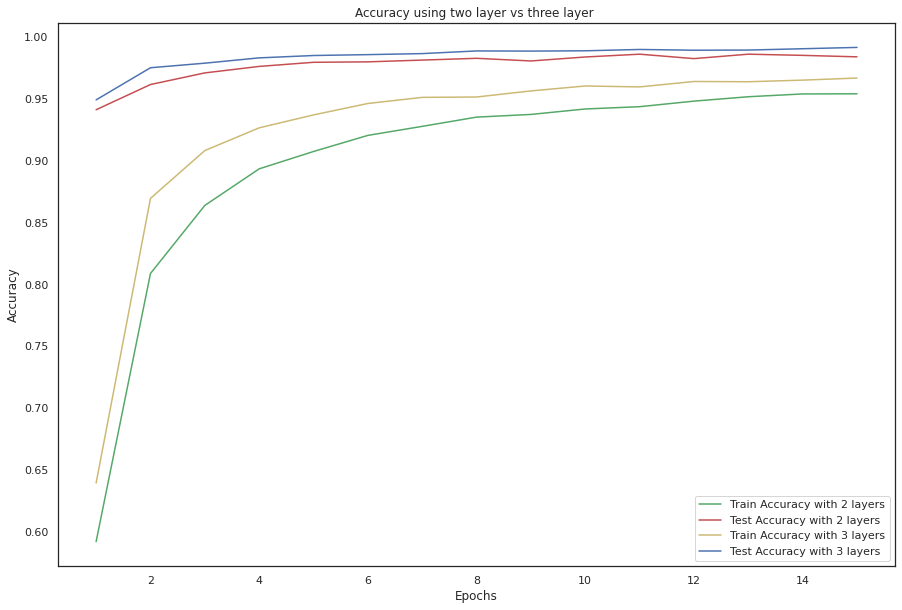

In [ ]:
#plot
accuracy_b= history_b.history['accuracy']
val_accuracy_b = history_b.history['val_accuracy']
epochs = range(1, len(accuracy_b) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, trn_1, 'g', label='Train Accuracy with 2 layers')
plt.plot(epochs, val_1, 'r', label='Test Accuracy with 2 layers')
plt.plot(epochs, accuracy_b, 'y', label='Train Accuracy with 3 layers')
plt.plot(epochs, val_accuracy_b, 'b', label='Test Accuracy with 3 layers')
plt.title('Accuracy using two layer vs three layer ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

When we add 3 layers, the same affect happens, i.e we get more accuracy. Each layer will be capable of performing more feature extracton. Both the traning and testing accuracy, thereby increases